In [1]:
from scipy.interpolate import griddata
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import tensorflow as tf
from tensorflow.keras import layers, models

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-12-24 22:56:06.263598: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
import numpy as np
import plotly.offline as pyo
from plotly import subplots
import plotly.graph_objects as go

In [3]:
client = pd.read_csv("../../data/client.csv")
ePrices = pd.read_csv("../../data/electricity_prices.csv")
gasPrices = pd.read_csv("../../data/gas_prices.csv")
train = pd.read_csv("../../data/train.csv")

In [4]:
weatherPredInt = pd.read_csv("interpolPredWeather.csv")
weatherHistInt = pd.read_csv("../histWeatherSnowCover.csv")

# process data

### add sunlight feature

In [13]:
from datetime import datetime
from suntime import Sun
import pytz

sunrise = []
sunset = []
for i in range(0,weatherPredInt.shape[0]):
    sun = Sun(weatherPredInt.latitude.iloc[i], weatherPredInt.longitude.iloc[i])
    dt = pd.to_datetime(weatherPredInt.forecast_datetime.iloc[i])
    sunrise.append(sun.get_sunrise_time(dt))
    sunset.append(sun.get_sunset_time(dt))

#weatherPredInt['sunrise'] = sunrise
#weatherPredInt['sunset'] = sunset

weatherPredInt['forecast_datetime'] = pd.to_datetime(weatherPredInt['forecast_datetime'])
def is_daylight(row):
    sunrise = row['sunrise']
    sunset = row['sunset']
    datetime = row['forecast_datetime']
    return sunrise <= datetime <= sunset
def calc_daylight(row):
    sunrise = row['sunrise']
    sunset = row['sunset']
    return (sunset-sunrise).total_seconds()/60
#weatherPredInt['daylight'] = weatherPredInt.apply(is_daylight, axis=1)
#weatherPredInt['minDaylight'] = weatherPredInt.apply(calc_daylight, axis=1)

### merge client & train, add business feat & interpolate daylight savings

In [5]:
producing = train.loc[train.is_consumption == 0]
consuming = train.loc[train.is_consumption == 1]
train = pd.merge(producing.drop('is_consumption',axis = 1), consuming.drop('is_consumption',axis = 1),on=['data_block_id','prediction_unit_id','datetime','county','is_business','product_type'], how='outer',suffixes=('_prod', '_cons'))
del producing, consuming
print(train.shape)

clientsTime = pd.merge(train, client, on=['county','is_business','product_type','data_block_id'], how='inner')

clientsTime['datetime'] = pd.to_datetime(clientsTime['datetime'])
clientsTime['yearday'] = clientsTime['datetime'].dt.day_of_year
clientsTime['weekday'] = clientsTime['datetime'].dt.day_of_week
clientsTime['month'] = clientsTime['datetime'].dt.month

unique_pairs = list(set(zip(clientsTime['is_business'], clientsTime[ 'product_type'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs)}
clientsTime['business_prodType'] = list(map(pair_index_dict.get, zip(clientsTime['is_business'], clientsTime['product_type'])))

unique_pairs_cust = list(set(zip(clientsTime['is_business'], clientsTime[ 'product_type'], clientsTime['county'], clientsTime['eic_count'],clientsTime['installed_capacity'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs_cust)}
clientsTime['ind_customer_id'] = list(map(pair_index_dict.get, zip(clientsTime['is_business'], clientsTime['product_type'], clientsTime['county'], clientsTime['eic_count'],clientsTime['installed_capacity'])))

# interpolate daylight savings
clientsTime = clientsTime.interpolate()

(1009176, 10)


/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_4660/3104542257.py:23: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



### prepare electric prices

In [6]:
ePrices['forecast_date'] = pd.to_datetime(ePrices['forecast_date'])

# Set 'timestamp' as the index
ePrices.set_index('forecast_date', inplace=True)

# Resample to fill missing hours
df_resampled = ePrices.resample('1H').asfreq()

# Linearly interpolate missing values
ePrices = df_resampled.interpolate(method='linear')

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_4660/2052008978.py:10: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



# write data into python arrays

In [7]:
#clientsTime, weatherPredInt, weatherHistInt, ePrices, gasPrices

featPredWeather = [
        #'latitude', 'longitude', 
        'County', #'forecast_datetime',
       'hours_ahead',
        'data_block_id', #'origin_datetime', 
       'temperatureint',
       'dewpointint', 'cloudcover_highint', 'cloudcover_lowint',
       'cloudcover_midint', 'cloudcover_totalint',
       '10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       'snowfallint', 'total_precipitationint', 
       #'sunrise', 'sunset',
       #'daylight', 'minDaylight'
       ]

predWeatherComplete = weatherPredInt[featPredWeather]
del weatherPredInt

featHistWeather = [
       #'latitude', 'longitude', 
       'County',
       #'datetime', 
       'data_block_id', 
       'temperatureint', 'dewpointint', 'rainint',
       'snowfallint', 'surface_pressureint', 'cloudcover_totalint',
       'cloudcover_lowint', 'cloudcover_midint', 'cloudcover_highint',
       'windspeed_10mint', 'winddirection_10mint', 'shortwave_radiationint',
       'direct_solar_radiationint', 'diffuse_radiationint', 'meltingInCM',
       'snowHeightFlux', 'snowcover'
]
histWeatherComplete = weatherHistInt[featHistWeather]
del weatherHistInt

# can't use client id as an axis in data because it's not constant!
y = np.zeros((clientsTime.shape[0],2))
y_indexes = np.zeros((clientsTime.shape[0],2)) # dataframe indexes in the end, not important for now
index_y = 0

customers = []

constValsArray = np.zeros((1,10))
targetsArray = np.zeros((1,24,2))
ePricesArray = np.zeros((1,24,1))

nFeatHistWeather = histWeatherComplete.shape[1]-1
histWeatherArray = np.zeros((1,24,nFeatHistWeather))
nFeatPredWeather = predWeatherComplete.shape[1]-1
predWeatherArray = np.zeros((1,24,nFeatPredWeather))
dataBlockIdArray = np.zeros((1))

# loop over customer, append all data cycles for each customer
for customerId in clientsTime.ind_customer_id.unique():
    customerSlice = clientsTime.loc[clientsTime.ind_customer_id == customerId]

    # const values
    county       = customerSlice.county.unique()[0]
    is_business  = customerSlice.is_business.unique()[0]
    product_type = customerSlice.product_type.unique()[0]
    prediction_unit_id = customerSlice.prediction_unit_id.unique()[0] #should be redundant
    eic_count          = customerSlice.eic_count.unique()[0]
    installed_capacity = customerSlice.installed_capacity.unique()[0]
    yearday = customerSlice.yearday.unique()[0]
    weekday = customerSlice.weekday.unique()[0]
    month   = customerSlice.month.unique()[0]
    business_prodType = customerSlice.business_prodType.unique()[0]
    ind_customer_id   = customerSlice.ind_customer_id.unique()[0]

    for dataBlockId in customerSlice.data_block_id.unique():
        timeSlice = customerSlice.loc[customerSlice.data_block_id == dataBlockId]
        gasSlice = gasPrices.loc[gasPrices.data_block_id == dataBlockId]
        eSlice   = ePrices.loc[ePrices.data_block_id == dataBlockId]

        

        lowest_price_per_mwh = gasSlice.lowest_price_per_mwh.iloc[0]
        highest_price_per_mwh = gasSlice.highest_price_per_mwh.iloc[0]
        euros_per_mwh = eSlice['euros_per_mwh'].to_numpy()
        if euros_per_mwh.shape[0] == 23:
            print(dataBlockId, customerId)

        y_cons = timeSlice['target_cons'] / installed_capacity
        y_prod = timeSlice['target_prod'] / installed_capacity

        histWeather = histWeatherComplete.loc[(histWeatherComplete.data_block_id == dataBlockId) & (histWeatherComplete.County == county)]
        predWeather = predWeatherComplete.loc[(predWeatherComplete.data_block_id == dataBlockId) & (predWeatherComplete.County == county)]

        histWeather = histWeather.drop('data_block_id', axis = 1)
        predWeather = predWeather.drop('data_block_id', axis = 1)


        if y_cons.shape[0] == 23:
            print(dataBlockId, customerId)

        new_row = np.array([county, is_business, product_type, prediction_unit_id, eic_count, installed_capacity, business_prodType, ind_customer_id,lowest_price_per_mwh,highest_price_per_mwh])
        constValsArray = np.vstack((constValsArray, new_row))

        new_row = np.zeros((1,24,2))
        new_row[:,:,0] = y_cons
        new_row[:,:,1] = y_prod
        targetsArray = np.concatenate((targetsArray, new_row), axis=0)

        new_row = np.zeros((1,24,1))
        new_row[0,:,0] = euros_per_mwh
        ePricesArray = np.concatenate((ePricesArray, new_row), axis=0)

        new_row = np.zeros((1,24,nFeatHistWeather)) #without datablock id
        new_row[:,:,:] = histWeather
        histWeatherArray = np.concatenate((histWeatherArray, new_row), axis=0)

        new_row = np.zeros((1,24,nFeatPredWeather)) # withotu datablock id
        new_row[:,:,:] = predWeather
        predWeatherArray = np.concatenate((predWeatherArray, new_row), axis=0)

        dataBlockIdArray = np.concatenate((dataBlockIdArray, np.array([dataBlockId])))

    


In [8]:
#remove first rows
targetsArray     = targetsArray[1:,:,:]
constValsArray   = constValsArray[1:,:]
ePricesArray     = ePricesArray[1:,:,:]
histWeatherArray = histWeatherArray[1:,:,:]
predWeatherArray = predWeatherArray[1:,:,:]
dataBlockIdArray = dataBlockIdArray[1:]
print(targetsArray.shape, constValsArray.shape, ePricesArray.shape,histWeatherArray.shape, predWeatherArray.shape, dataBlockIdArray.shape)

(41869, 24, 2) (41869, 10) (41869, 24, 1) (41869, 24, 18) (41869, 24, 14) (41869,)


In [9]:
#calc absolute targets, not normalized by capacity
targetsAbs = targetsArray.copy()
targetsAbs = targetsAbs * constValsArray[:,5].reshape(constValsArray.shape[0],1,1)
print(targetsAbs.shape)

(41869, 24, 2)


In [10]:
print(targetsArray.shape, constValsArray.shape, ePricesArray.shape,histWeatherArray.shape, predWeatherArray.shape, dataBlockIdArray.shape)

(41869, 24, 2) (41869, 10) (41869, 24, 1) (41869, 24, 18) (41869, 24, 14) (41869,)


In [11]:
np.savez('data_arrays_snowcover_GasPr_noSunrise.npz', arr1=targetsArray, arr2=constValsArray, arr3=ePricesArray, arr4 = histWeatherArray, arr5=predWeatherArray, arr6=dataBlockIdArray, arr7=targetsAbs)

# load data

In [12]:
loaded_data = np.load('data_arrays_snowcover_GasPr_noSunrise.npz')

# Access individual arrays by their keys
targetsArray = loaded_data['arr1']
constValsArray = loaded_data['arr2']
ePricesArray = loaded_data['arr3']
histWeatherArray = loaded_data['arr4']
predWeatherArray = loaded_data['arr5']
dataBlockIdArray = loaded_data['arr6']
targetsAbs = loaded_data['arr7']

# build a model & train it

In [13]:
tf.random.set_seed(42)
from sklearn.model_selection import train_test_split

### shuffle if needed & split into x train y train

In [14]:
np.random.seed(42)
index_array = np.arange(targetsArray.shape[0])
np.random.shuffle(index_array)
arrays = [constValsArray,ePricesArray,histWeatherArray,predWeatherArray,targetsAbs,targetsArray,dataBlockIdArray]
shuffledArr = [arr[index_array] for arr in arrays]
del arrays

In [15]:
trainSplit = int(shuffledArr[4].shape[0]*0.8)
X_train = [shuffledArr[0][0:trainSplit,:],shuffledArr[1][0:trainSplit,:,:],shuffledArr[2][0:trainSplit,:,:],shuffledArr[3][0:trainSplit,:,:]]
y_trainAbs = shuffledArr[4][0:trainSplit,:]
y_train = shuffledArr[5][0:trainSplit,:]

X_test = [shuffledArr[0][trainSplit:-1,:],shuffledArr[1][trainSplit:-1,:,:],shuffledArr[2][trainSplit:-1,:,:],shuffledArr[3][trainSplit:-1,:,:]]
y_testAbs = shuffledArr[4][trainSplit:-1,:]
y_test = shuffledArr[5][trainSplit:-1,:]

In [ ]:
del targetsArray ,constValsArray   ,ePricesArray     ,histWeatherArray ,predWeatherArray ,dataBlockIdArray ,targetsAbs

### split unshuffled data

In [7]:
trainSplit = int(targetsArray.shape[0]*0.3)
X_train = [constValsArray[0:trainSplit,:],ePricesArray[0:trainSplit,:,:],histWeatherArray[0:trainSplit,:,:],predWeatherArray[0:trainSplit,:,:]]
y_train = targetsArray[0:trainSplit,:]
y_trainAbs = targetsAbs[0:trainSplit,:]

X_test = [constValsArray[trainSplit:-1,:],ePricesArray[trainSplit:-1,:,:],histWeatherArray[trainSplit:-1,:,:],predWeatherArray[trainSplit:-1,:,:]]
y_test = targetsArray[trainSplit:-1,:]
y_testAbs = targetsAbs[trainSplit:-1,:]

### define model & train it

#### model with 2 outputs

In [ ]:
# Define the inputs
weatherPred_inputs = tf.keras.Input(shape=(24, 16), name='weatherPred_inputs')
ePrices_inputs = tf.keras.Input(shape=(24, 1), name='ePrices_inputs')

weatherHist_input = tf.keras.Input(shape=(24, 18), name='weatherHist_input')
constant_inputs = tf.keras.Input(shape=(8,), name='constant_inputs')

# Process the time-based inputs
weatherPred_flattened = layers.Flatten()(weatherPred_inputs)
weatherPred_flattened = layers.Dense(408, activation='relu')(weatherPred_flattened)
weatherPred_flattened = layers.Dense(408, activation='relu')(weatherPred_flattened)
weatherPred_flattened = layers.Dense(408, activation='relu')(weatherPred_flattened)
#weatherPred_flattened = layers.Dense(256, activation='relu')(weatherPred_flattened)
#weatherPred_flattened = layers.Dense(64, activation='relu')(weatherPred_flattened)

weatherHist_flattened = layers.Flatten()(weatherHist_input)
weatherHist_flattened = layers.Dense(240, activation='relu')(weatherHist_flattened)
weatherHist_flattened = layers.Dense(240, activation='relu')(weatherHist_flattened)
weatherHist_flattened = layers.Dense(240, activation='relu')(weatherHist_flattened)
#weatherHist_flattened = layers.Dense(64, activation='relu')(weatherHist_flattened)

ePrices_layer = layers.Flatten()(ePrices_inputs)
ePrices_layer = layers.Dense(24, activation='relu')(ePrices_layer)

# Concatenate all inputs
x = layers.Concatenate()([weatherPred_flattened, weatherHist_flattened, ePrices_layer, constant_inputs])

# Main dense block
for i in range(0,5):
    x = layers.Dense(540, activation='relu')(x)
    #x = layers.Dropout(0.1)(x)

# Output layer for 24*2 targets
output_layer = layers.Dense(24 * 2, activation='linear', name='output')(x)
output_layer = layers.Reshape((24, 2))(output_layer)

In [ ]:
model = models.Model(inputs=[constant_inputs,ePrices_inputs, weatherHist_input, weatherPred_inputs], outputs=output_layer)

# Compile the model with an appropriate loss function and optimizer
model.compile(optimizer='adam', loss='mae', metrics=['mae','mse'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=200) #batch size = 110 weather station

In [ ]:
fig = go.Figure()
length = len(history.history['loss'])
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(
    title='Training and Validation Loss Over Epochs',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(x=0, y=1, traceorder='normal'),
)
fig.show()

In [ ]:
a = model.predict(X_test)
predVals = a*X_test[0][:,5].reshape(X_test[0].shape[0],1,1)
print(np.mean(np.abs(y_testAbs - predVals)))
a = model.predict(X_train)
predVals = a*X_train[0][:,5].reshape(X_train[0].shape[0],1,1)
trueVals = targetsAbs[0:trainSplit,:]
print(np.mean(np.abs(y_trainAbs - predVals)))
del a,predVals,trueVals

### use a model for production and consumption separately

In [34]:
# Define the inputs
weatherPred_inputs1 = tf.keras.Input(shape=(24, 14), name='weatherPred_inputs1')
ePrices_inputs1 = tf.keras.Input(shape=(24, 1), name='ePrices_inputs1')

weatherHist_input1 = tf.keras.Input(shape=(24, 18), name='weatherHist_input1')
constant_inputs1 = tf.keras.Input(shape=(10,), name='constant_inputs1')

# Process the time-based inputs
weatherPred_flattened1 = layers.Flatten()(weatherPred_inputs1)
for i in range(0,3):
    weatherPred_flattened1 = layers.Dense(408, activation='relu')(weatherPred_flattened1)

weatherHist_flattened1 = layers.Flatten()(weatherHist_input1)
for i in range(0,3):
    weatherHist_flattened1 = layers.Dense(240, activation='relu')(weatherHist_flattened1)

ePrices_layer1 = layers.Flatten()(ePrices_inputs1)
ePrices_layer1 = layers.Dense(24, activation='relu')(ePrices_layer1)

# Concatenate all inputs
x1 = layers.Concatenate()([weatherPred_flattened1, weatherHist_flattened1, ePrices_layer1, constant_inputs1])

# Main dense block
for i in range(0,5):
    x1 = layers.Dense(540, activation='relu')(x1)
    #x = layers.Dropout(0.1)(x)

# Output layer for 24*2 targets
output_layer1 = layers.Dense(24 * 1, activation='linear', name='output1')(x1)
output_layer1 = layers.Reshape((24, 1))(output_layer1)

model2 = models.Model(inputs=[constant_inputs1,ePrices_inputs1, weatherHist_input1, weatherPred_inputs1], outputs=output_layer1)

# Compile the model with an appropriate loss function and optimizer
model2.compile(optimizer='adam', loss='mae', metrics=['mae'])
# 0 = cons, 1 = prod
history2 = model2.fit(X_train, y_trainAbs[:,:,1], validation_data=(X_test, y_testAbs[:,:,1]), epochs=100, batch_size=400) #batch size = 110 weather station

Epoch 1/100
84/84 [==============================] - 6s 69ms/step - loss: 1.5640 - mae: 1.5640 - val_loss: 0.0794 - val_mae: 0.0794
Epoch 2/100
84/84 [==============================] - 6s 66ms/step - loss: 0.0659 - mae: 0.0659 - val_loss: 0.0501 - val_mae: 0.0501
Epoch 3/100
84/84 [==============================] - 5s 65ms/step - loss: 0.0467 - mae: 0.0467 - val_loss: 0.0429 - val_mae: 0.0429
Epoch 4/100
84/84 [==============================] - 5s 66ms/step - loss: 0.0392 - mae: 0.0392 - val_loss: 0.0361 - val_mae: 0.0361
Epoch 5/100
84/84 [==============================] - 6s 66ms/step - loss: 0.0346 - mae: 0.0346 - val_loss: 0.0313 - val_mae: 0.0313
Epoch 6/100
84/84 [==============================] - 6s 67ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0302 - val_mae: 0.0302
Epoch 7/100
84/84 [==============================] - 6s 70ms/step - loss: 0.0301 - mae: 0.0301 - val_loss: 0.0283 - val_mae: 0.0283
Epoch 8/100
84/84 [==============================] - 6s 68ms/step - loss: 0.

In [19]:
# Define the inputs
weatherPred_inputs2 = tf.keras.Input(shape=(24, 14), name='weatherPred_inputs2')
ePrices_inputs2 = tf.keras.Input(shape=(24, 1), name='ePrices_inputs2')

weatherHist_input2 = tf.keras.Input(shape=(24, 18), name='weatherHist_input2')
constant_inputs2 = tf.keras.Input(shape=(10,), name='constant_inputs2')

# Process the time-based inputs
weatherPred_flattened2 = layers.Flatten()(weatherPred_inputs2)
for i in range(0,3):
    weatherPred_flattened2 = layers.Dense(408, activation='relu')(weatherPred_flattened2)

weatherHist_flattened2 = layers.Flatten()(weatherHist_input2)
for i in range(0,3):
    weatherHist_flattened2 = layers.Dense(240, activation='relu')(weatherHist_flattened2)

ePrices_layer2 = layers.Flatten()(ePrices_inputs2)
ePrices_layer2 = layers.Dense(24, activation='relu')(ePrices_layer2)

# Concatenate all inputs
x2 = layers.Concatenate()([weatherPred_flattened2, weatherHist_flattened2, ePrices_layer2, constant_inputs2])

# Main dense block
for i in range(0,5):
    x2 = layers.Dense(540, activation='relu')(x2)
    #x = layers.Dropout(0.1)(x)

# Output layer for 24*2 targets
output_layer2 = layers.Dense(24 * 1, activation='linear', name='output')(x2)
output_layer2 = layers.Reshape((24, 1))(output_layer2)

model3 = tf.keras.Model(inputs=[constant_inputs2,ePrices_inputs2, weatherHist_input2, weatherPred_inputs2], outputs=output_layer2)

# Compile the model with an appropriate loss function and optimizer
model3.compile(optimizer='adam', loss='mae', metrics=['mae'])
# 0 = cons, 1 = prod
history3 = model3.fit(X_train, y_trainAbs[:,:,0], validation_data=(X_test, y_testAbs[:,:,0]), epochs=100, batch_size=200) #batch size = 110 weather station

Epoch 1/100
168/168 [==============================] - 8s 42ms/step - loss: 217.4719 - mae: 217.4719 - val_loss: 162.8275 - val_mae: 162.8275
Epoch 2/100
168/168 [==============================] - 7s 40ms/step - loss: 163.3667 - mae: 163.3667 - val_loss: 150.8122 - val_mae: 150.8122
Epoch 3/100
168/168 [==============================] - 7s 41ms/step - loss: 145.8367 - mae: 145.8367 - val_loss: 136.6228 - val_mae: 136.6228
Epoch 4/100
168/168 [==============================] - 7s 41ms/step - loss: 150.4096 - mae: 150.4096 - val_loss: 140.2688 - val_mae: 140.2688
Epoch 5/100
168/168 [==============================] - 7s 43ms/step - loss: 135.6758 - mae: 135.6758 - val_loss: 128.7624 - val_mae: 128.7624
Epoch 6/100
168/168 [==============================] - 7s 43ms/step - loss: 129.6979 - mae: 129.6979 - val_loss: 128.3567 - val_mae: 128.3567
Epoch 7/100
168/168 [==============================] - 7s 44ms/step - loss: 124.4563 - mae: 124.4563 - val_loss: 122.9142 - val_mae: 122.9142
Epoch 

In [23]:
fig = go.Figure()
length = len(history3.history['loss'])
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history3.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history3.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(
    title='Training and Validation Loss Over Epochs',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(x=0, y=1, traceorder='normal'),
)
fig.show()

In [35]:
a = model2.predict(X_test)
predVals = a*X_test[0][:,5].reshape(X_test[0].shape[0],1,1)
print(np.mean(np.abs(y_testAbs - predVals)))
a = model2.predict(X_train)
predVals = a*X_train[0][:,5].reshape(X_train[0].shape[0],1,1)
trueVals = targetsAbs[0:trainSplit,:]
print(np.mean(np.abs(y_trainAbs - predVals)))
del a,predVals,trueVals

# mean cons error combined for a relative train = 770
# mean cons error single trained (relative train) = 290
# mean cons error single traines =43 (train) 60-63 (test)
# mean prod error single trainer = 9-20

262/262 [==============================] - 2s 5ms/step
242.66145104438638
1047/1047 [==============================] - 5s 5ms/step
248.9262681579961


In [20]:
model2.save('prod_model_GasPr_noSunrise.h5')
model3.save('cons_model_GasPr_noSunrise.h5')

# reconstruct dataframe and analyse results

In [29]:
# restructure dataframes
appendedList = []
shuffledDataBlockId = shuffledArr[6]
for i,data_block_id in enumerate(shuffledDataBlockId):
    isTrain = False
    if i<trainSplit:
        isTrain=True
    
    new_columns = np.zeros((24, 2))  # Adjust the size according to your requirements

    #use targets as first block
    dataBlock = shuffledArr[4][i,:,:].reshape(24,2)

    #add train/test info & data block id
    new_columns = np.ones((24, 2)) * [isTrain, data_block_id]
    dataBlock = np.hstack((dataBlock, new_columns))
    #add const values
    new_columns = np.ones((24, 8)) * shuffledArr[0][i,:].reshape(1,8)
    dataBlock = np.hstack((dataBlock, new_columns))
    #eprices (of yesterday)
    dataBlock = np.hstack((dataBlock, shuffledArr[1][i,:,:].reshape(24,1)))
    # add weather prediction
    dataBlock = np.hstack((dataBlock, shuffledArr[3][i,:,:].reshape(24,16)))
    # hist weather
    dataBlock = np.hstack((dataBlock, shuffledArr[2][i,:,:].reshape(24,18)))

    #hist weather, flatten the array and add all values as columns
    #new_columns = np.ones((24, 100)) * shuffledArr[2][i,:].reshape(1,100)
    #dataBlock = np.hstack((dataBlock, new_columns))

    appendedList.append(dataBlock)



featPredWeather = [
        #'latitude', 'longitude', 
        'County', #'forecast_datetime',
       'hours_ahead',
        #'data_block_id_predWeather', #'origin_datetime', 
       'temperatureint',
       'dewpointint', 'cloudcover_highint', 'cloudcover_lowint',
       'cloudcover_midint', 'cloudcover_totalint',
       '10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       'snowfallint', 'total_precipitationint', 
       #'sunrise', 'sunset',
       'daylight', 'minDaylight']

featHistWeather = [
       #'County', #'forecast_datetime',
       #'hours_ahead', #'data_block_id_histWeather',# 'origin_datetime',
       #'diff_dewpoint', 'diff_cloudcover_total', 'diff_direct_solar_radiation',
       #'diff_surface_solar_radiation_downwards', 'diff_snowfall',
       #'diff_10_metre_u_wind_component', 'diff_10_metre_v_wind_component'
       'County',
       #'datetime', 
       #'data_block_id', 
       'temperatureint', 'dewpointint', 'rainint',
       'snowfallint', 'surface_pressureint', 'cloudcover_totalint',
       'cloudcover_lowint', 'cloudcover_midint', 'cloudcover_highint',
       'windspeed_10mint', 'winddirection_10mint', 'shortwave_radiationint',
       'direct_solar_radiationint', 'diffuse_radiationint', 'meltingInCM',
       'snowHeightFlux', 'snowcover'
]
featConst =['county', 'is_business', 'product_type', 'prediction_unit_id', 'eic_count', 'installed_capacity', 'business_prodType', 'ind_customer_id']

feat = ['y_cons','y_prod','isTrain','data_block_id'] + featConst + ['ePrices'] + featPredWeather +featHistWeather
#for i in range(0,10):
#    feat = feat + [f'{value}_'+str(i) for value in featHistWeather]

appendedDf = pd.DataFrame(np.vstack(appendedList), columns=feat)
    
            

In [ ]:
appendedDf.to_csv('appendedDf_snowcover_relativeTrain.csv')

In [24]:
appendedDf = pd.read_csv('appendedDf_snowcover_relativeTrain.csv')

In [30]:
X2 = [shuffledArr[0],shuffledArr[1],shuffledArr[2],shuffledArr[3]]
pred_prod = model2.predict(X2)
pred_cons = model3.predict(X2)

appendedListCons = []
for i in range(0,pred_cons.shape[0]):
    appendedListCons.append(pred_cons[i,:,:].reshape(24,1))
predDfc = pd.DataFrame(np.vstack(appendedListCons), columns=['pred_cons'])


appendedListProd = []
for i in range(0,pred_prod.shape[0]):
    appendedListProd.append(pred_prod[i,:,:].reshape(24,1))
predDfp = pd.DataFrame(np.vstack(appendedListProd), columns=['pred_prod'])


1309/1309 [==============================] - 6s 4ms/step


In [ ]:
del X_train, X_test,y_train,y_trainAbs,y_test,y_testAbs,loaded_data#,shuffledArr

In [ ]:
appendedList = []
for ind in range(0,pred.shape[0]):
    appendedList.append(pred[i,:,:].reshape(24,2))
predDf = pd.DataFrame(np.vstack(appendedList), columns=['pred_cons','pred_prod'])

In [31]:
appendedDf = pd.concat([appendedDf, predDfc], axis = 1)
appendedDf = pd.concat([appendedDf, predDfp], axis = 1)
appendedDf.head(5)

,y_cons,y_prod,isTrain,data_block_id,county,is_business,product_type,prediction_unit_id,eic_count,installed_capacity,...,windspeed_10mint,winddirection_10mint,shortwave_radiationint,direct_solar_radiationint,diffuse_radiationint,meltingInCM,snowHeightFlux,snowcover,pred_cons,pred_prod
0,51.669,0.579,1.0,601.0,5.0,0.0,1.0,19.0,61.0,643.3,...,2.543546,221.498360,547.409970,453.516317,93.893654,-1.170695,-1.170695,0.0,493.681396,-0.277551
1,45.858,0.652,1.0,601.0,5.0,0.0,1.0,19.0,61.0,643.3,...,2.477676,210.040341,631.234134,531.651812,99.582322,-1.261914,-1.261914,0.0,474.690247,0.419703
2,43.995,0.357,1.0,601.0,5.0,0.0,1.0,19.0,61.0,643.3,...,2.777206,185.555715,679.369630,576.475976,102.893654,-1.332957,-1.332957,0.0,473.395294,0.342090
3,46.000,0.002,1.0,601.0,5.0,0.0,1.0,19.0,61.0,643.3,...,3.179413,184.584864,687.853313,584.270991,103.582322,-1.390353,-1.390353,0.0,463.800568,1.647683
4,51.837,0.000,1.0,601.0,5.0,0.0,1.0,19.0,61.0,643.3,...,3.403947,190.584864,656.095154,554.890169,101.204985,-1.430375,-1.430375,0.0,465.785309,0.280093


In [32]:
appendedDf['absErr_cons'] = (appendedDf['y_cons']-appendedDf['pred_cons'])
appendedDf['absErr_prod'] = (appendedDf['y_prod']-appendedDf['pred_prod'])

# analyze dataframe
good generalization, test and train are pretty much always the same

production:
- overweighting big producers -> lots of errors for smaller capacities

consumption:
- bigger error in summer


In [25]:
trainDf = appendedDf.loc[appendedDf.isTrain == True]
testDf = appendedDf.loc[appendedDf.isTrain == False]

In [27]:
appendedDf['consTarg-Cap'] = appendedDf['y_cons'] - appendedDf['installed_capacity']
appendedDf['prodTarg-Cap'] = appendedDf['y_prod'] - appendedDf['installed_capacity']

In [33]:
appendedDf['y_prod'].max()

11255.665

<Axes: >

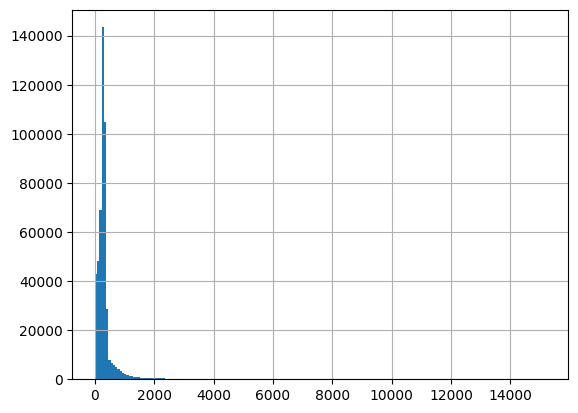

In [36]:
testDf.absErr_cons.hist(bins=200)

<Axes: >

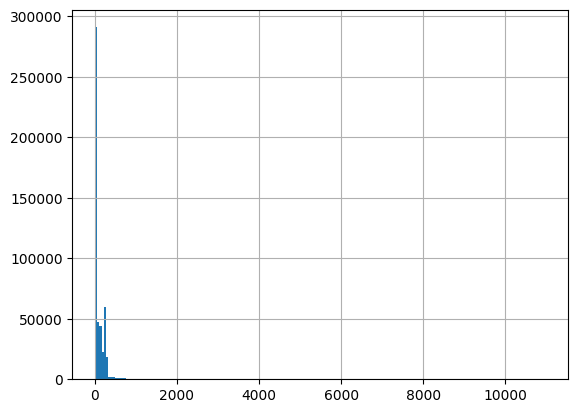

In [37]:
testDf.absErr_prod.hist(bins=200)

<Axes: >

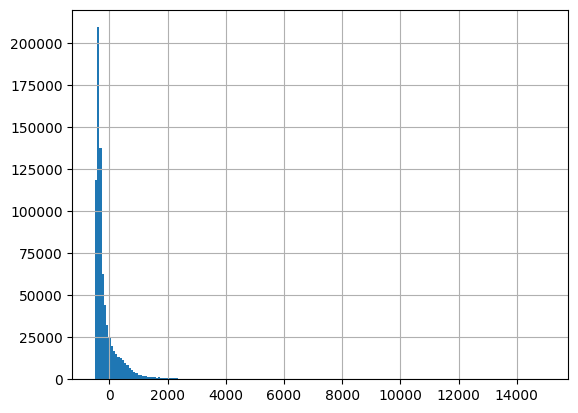

In [36]:
trainDf.absErr_cons.hist(bins=200)

<Axes: >

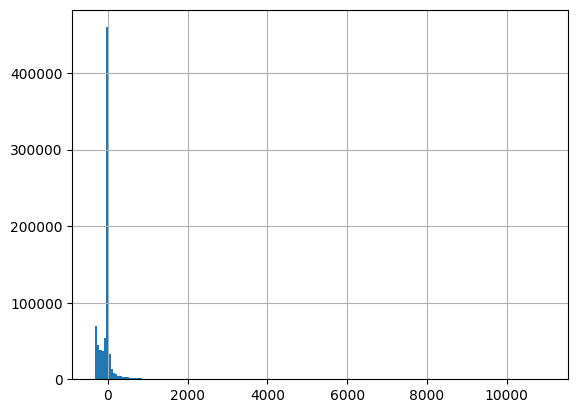

In [37]:
trainDf.absErr_prod.hist(bins=200)

### investigate consumption

In [ ]:
testDf.groupby('data_block_id')['absErr_cons'].mean().plot() 

In [ ]:
abs(testDf.absErr_prod).mean()

In [ ]:
testDf.absErr_cons.mean()

In [ ]:
testDf.groupby('minDaylight')['absErr_prod'].max().plot() #hist(bins=100)

In [ ]:
testDf.loc[testDf.absErr_prod <100].data_block_id.hist(bins=20)

In [ ]:
fig = subplots.make_subplots(rows=1, cols=1,shared_xaxes=True)
fig.add_trace(go.Scatter(x = testDf['data_block_id'], y = testDf['absErr_cons'],mode ='markers', name='diff_snowfall'),row=1, col=1)
fig.show()